# Project Group 13 - DS-3000

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Install extra packages
%pip install rapidfuzz unidecode tqdm xgboost

# =========================
# Imports
# =========================
import re
import unicodedata
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rapidfuzz import fuzz, process
from unidecode import unidecode
from tqdm import tqdm
from pandas.api.types import is_numeric_dtype

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
    GridSearchCV,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
)

from xgboost import XGBRegressor

SEED = 42
np.random.seed(SEED)

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 15.8 MB/s eta 0:00:00


In [ ]:
# ==========================================================
# Helper Functions
# ==========================================================

def clean_name(name):
    if pd.isna(name):
        return ""
    name = str(name).strip().lower()
    name = unicodedata.normalize('NFKD', name).encode('ASCII', 'ignore').decode('utf-8')
    name = re.sub(r'[^a-z0-9 ]', '', name)
    return name

def normalize_name(name: str) -> str:
    if pd.isna(name):
        return ""
    s = unidecode(str(name)).lower()
    s = re.sub(r"[^a-z\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def nation_code_to_full(nation_field: str) -> str:
    if pd.isna(nation_field):
        return None
    first_token = str(nation_field).split()[0].lower()
    return code_to_country.get(first_token)


def clean_club(name):
    if pd.isna(name):
        return ""
    n = unidecode(str(name)).lower()
    n = re.sub(r"[^a-z0-9 ]", " ", n)
    n = re.sub(r"\s+", " ", n).strip()
    return n

In [ ]:
# ==========================================================
# Loading the FC26 dataset
# ==========================================================

# File path
fc_2026_file_path = '/content/drive/MyDrive/Colab Notebooks/Project/FC26.csv'

# Load dataset safely (avoids mixed-type chunking warning)
fc_df = pd.read_csv(fc_2026_file_path, low_memory=False)

print("Original FC26 shape:", fc_df.shape)

# --- Clean positional rating columns containing strings like "86+3" ---
fc_position_cols = [
    "ls","st","rs","lw","lf","cf","rf","rw",
    "lam","cam","ram",
    "lm","lcm","cm","rcm","rm",
    "lwb","ldm","cdm","rdm","rwb",
    "lb","lcb","cb","rcb","rb",
    "gk"
]

def clean_position_value(val):
    if pd.isna(val):
        return np.nan
    val = str(val).strip()
    if "+" in val:                 # format "86+3"
        base = val.split("+")[0]   # keep only base rating
        return pd.to_numeric(base, errors="coerce")
    return pd.to_numeric(val, errors="coerce")

for col in fc_position_cols:
    if col in fc_df.columns:
        fc_df[col] = fc_df[col].apply(clean_position_value)

fc_df['player_long_name'] = fc_df['long_name'].apply(clean_name)
fc_df['player_short_name'] = fc_df['short_name'].apply(clean_name)
fc_df['club_name'] = fc_df['club_name'].apply(clean_name)

# --- Keep only columns needed for merging + ratings ---
fc_rating_cols = ['player_positions', 'nationality_name','overall','pace','shooting','passing','dribbling','defending','physic']
fc_merge_cols = ['player_long_name','player_short_name','club_name', 'club_loaned_from', 'dob'] + fc_rating_cols
fc_df_merge = fc_df[fc_merge_cols].copy()

# --- Add FC26 prefix to rating columns ---
fc_df_merge = fc_df_merge.rename(columns={col: f"FC26_{col}" for col in fc_rating_cols})

print("FC26 shape", fc_df_merge.shape)
columns_to_show = [
    "player_long_name",
    "player_short_name",
    "club_name",
    "FC26_overall",
    "FC26_pace",
    "FC26_shooting",
    "FC26_passing",
    "FC26_dribbling",
    "FC26_defending",
    "FC26_physic"
]

display(fc_df_merge[columns_to_show].head(5))



Original FC26 shape: (18405, 110)
FC26 shape (18405, 14)


,player_long_name,player_short_name,club_name,FC26_overall,FC26_pace,FC26_shooting,FC26_passing,FC26_dribbling,FC26_defending,FC26_physic
0,jude victor william bellingham,j bellingham,real madrid,90,80.0,86.0,83.0,90.0,78.0,85.0
1,federico santiago valverde dipetta,f valverde,real madrid,89,88.0,84.0,84.0,84.0,83.0,85.0
2,joshua walter kimmich,j kimmich,fc bayern munchen,89,72.0,74.0,89.0,84.0,83.0,79.0
3,achraf hakimi mouh,a hakimi,paris saintgermain,89,92.0,79.0,82.0,83.0,82.0,79.0
4,nicolo barella,n barella,inter,87,80.0,78.0,84.0,86.0,81.0,76.0


In [ ]:
# ==========================================================
# Loading the real-world player dataset (2024-2025)
# ==========================================================

player_stats_file_path = '/content/drive/MyDrive/Colab Notebooks/Project/players_data-2024_2025.csv'

# Desired columns we want to extract
desired_columns = [

    # Basic Player Information
    "Player", "Nation", "Pos", "Squad", "Comp",
    "Age", "Born",

    # Playing Time & Appearances
    "MP", "Starts", "Min", "90s",

    # Attacking Stats
    "Gls", "Ast", "G+A", "xG", "xAG", "npxG", "G-PK",
    "PK", "PKatt",

    # Defensive Stats
    "Tkl", "TklW", "Blocks", "Int", "Tkl+Int",
    "Clr", "Err", "PKcon", "Recov",
    "CrdY", "CrdR",

    # Passing & Creativity Stats
    "PrgP", "PrgC", "KP",
    "Cmp%_stats_passing",
    "Ast_stats_passing",
    "xA", "PPA",

    # Possession & Ball Control
    "Touches", "Carries", "PrgR",
    "Mis", "Dis", "PKwon"
]

# Load headers first to confirm column availability
temp_df = pd.read_csv(player_stats_file_path, nrows=0)
existing_columns = [c for c in desired_columns if c in temp_df.columns]

# Load dataset with only the columns that exist
players_stats_df = pd.read_csv(
    player_stats_file_path,
    usecols=existing_columns,
    dtype=str,
    low_memory=False
)

# --- Clean names and clubs for merging ---
players_stats_df['player_name'] = players_stats_df['Player'].apply(clean_name)
players_stats_df['club_name'] = players_stats_df['Squad'].apply(clean_name)

# --- Clean column names (safe standardization) ---
players_stats_df.columns = (
    players_stats_df.columns
    .str.strip()
    .str.replace(r"[^\w\s]", "", regex=True)
    .str.replace(" ", "_")
)

# Identify non-numeric fields
non_numeric_cols = ["Player", "Squad", "Nation", "Pos", "Comp",
                    "player_name", "club_name"]

numeric_cols = [c for c in players_stats_df.columns if c not in non_numeric_cols]

# Convert numeric columns safely
for col in numeric_cols:
    players_stats_df[col] = pd.to_numeric(players_stats_df[col], errors="coerce")

# ==========================================================
# Final selected columns for consistent output (like FC26)
# ==========================================================

stats_columns_to_show = [
    "player_name",
    "club_name",
    "Nation",
    "Pos",
    "MP",
    "Starts",
    "Min",
    "90s",
    "Gls",
    "Ast",
    "xG",
    "xAG",
    "PrgP",
    "PrgC",
]

# Restrict display to meaningful subset
print("Cleaned player stats shape:", players_stats_df.shape)
print("Unique players:", players_stats_df['player_name'].nunique())

display(players_stats_df[stats_columns_to_show].head(5))


Cleaned player stats shape: (2854, 45)
Unique players: 2701


,player_name,club_name,Nation,Pos,MP,Starts,Min,90s,Gls,Ast,xG,xAG,PrgP,PrgC
0,max aarons,bournemouth,eng ENG,DF,3,1,86,1.0,0,0,0.0,0.0,8,1
1,max aarons,valencia,eng ENG,"DF,MF",4,1,120,1.3,0,0,0.0,0.0,6,0
2,rodrigo abajas,valencia,es ESP,DF,1,1,65,0.7,0,0,0.1,0.0,2,3
3,james abankwah,udinese,ie IRL,"DF,MF",6,0,88,1.0,0,0,0.1,0.0,4,3
4,keyliane abdallah,marseille,fr FRA,FW,1,0,3,0.0,0,0,0.0,0.0,0,1


In [ ]:
# ==========================================================
# MERGING FC26 RATINGS WITH REAL-WORLD PLAYER STATS
# ==========================================================

print("FC26 dataset shape:", fc_df.shape)
print("Real stats dataset shape:", players_stats_df.shape)

# -------------------------------------------------
# 1. Nationality + club mappings
# -------------------------------------------------

squad_to_fc26_club = {
    "Alavés": "Deportivo Alavés",
    "Angers": "Angers SCO",
    "Arsenal": "Arsenal",
    "Aston Villa": "Aston Villa",
    "Atalanta": "Atalanta",
    "Athletic Club": "Athletic Club",
    "Atlético Madrid": "Atlético Madrid",
    "Augsburg": "FC Augsburg",
    "Auxerre": "AJ Auxerre",
    "Barcelona": "FC Barcelona",
    "Bayern Munich": "FC Bayern München",
    "Betis": "Real Betis Balompié",
    "Bochum": "VfL Bochum 1848",
    "Bologna": "Bologna",
    "Bournemouth": "AFC Bournemouth",
    "Brentford": "Brentford",
    "Brest": "Stade Brestois 29",
    "Brighton": "Brighton & Hove Albion",
    "Cádiz": "Cádiz CF",
    "Cagliari": "Cagliari",
    "Celta Vigo": "RC Celta",
    "Chelsea": "Chelsea",
    "Clermont Foot": "Clermont Foot 63",
    "Cologne": "1. FC Köln",
    "Como": "Como",
    "Crystal Palace": "Crystal Palace",
    "Darmstadt": "SV Darmstadt 98",
    "Dortmund": "Borussia Dortmund",
    "Empoli": "Empoli",
    "Everton": "Everton",
    "Fiorentina": "Fiorentina",
    "Fortuna Düsseldorf": "Fortuna Düsseldorf",
    "Freiburg": "Sport-Club Freiburg",
    "Fulham": "Fulham",
    "Frosinone": "Frosinone",
    "Getafe": "Getafe CF",
    "Genoa": "Genoa",
    "Girona": "Girona FC",
    "Gladbach": "Borussia Mönchengladbach",
    "Granada": "Granada CF",
    "Hellas Verona": "Hellas Verona",
    "Hoffenheim": "TSG Hoffenheim",
    "Inter": "Inter Milan",
    "Juventus": "Juventus",
    "Lazio": "Lazio",
    "Lens": "RC Lens",
    "Lille": "LOSC Lille",
    "Liverpool": "Liverpool",
    "Lorient": "FC Lorient",
    "Luton Town": "Luton Town",
    "Mainz": "1. FSV Mainz 05",
    "Mallorca": "RCD Mallorca",
    "Manchester City": "Manchester City",
    "Manchester Utd": "Manchester United",
    "Marseille": "Olympique de Marseille",
    "Metz": "FC Metz",
    "Milan": "AC Milan",
    "Monaco": "AS Monaco",
    "Montpellier": "Montpellier HSC",
    "Nantes": "FC Nantes",
    "Napoli": "Napoli",
    "Nice": "OGC Nice",
    "Nottingham Forest": "Nottingham Forest",
    "Osasuna": "CA Osasuna",
    "PSG": "Paris Saint-Germain",
    "Porto": "FC Porto",
    "Rayo Vallecano": "Rayo Vallecano",
    "Real Madrid": "Real Madrid CF",
    "Real Sociedad": "Real Sociedad",
    "Reims": "Stade de Reims",
    "Rennes": "Stade Rennais",
    "Roma": "AS Roma",
    "Salernitana": "US Salernitana 1919",
    "Sassuolo": "Sassuolo",
    "Sevilla": "Sevilla FC",
    "Sheffield United": "Sheffield United",
    "Southampton": "Southampton",
    "Strasbourg": "RC Strasbourg Alsace",
    "Stuttgart": "VfB Stuttgart",
    "Torino": "Torino",
    "Tottenham": "Tottenham Hotspur",
    "Toulouse": "Toulouse FC",
    "Udinese": "Udinese",
    "Union Berlin": "1. FC Union Berlin",
    "Valencia": "Valencia CF",
    "Valladolid": "Real Valladolid CF",
    "Venezia": "Venezia",
    "Villarreal": "Villarreal CF",
    "Werder Bremen": "SV Werder Bremen",
    "West Ham": "West Ham United",
    "Wolfsburg": "VfL Wolfsburg",
    "Wolves": "Wolverhampton Wanderers"
}

code_to_country = {
    "al": "Albania",
    "am": "Armenia",
    "ao": "Angola",
    "ar": "Argentina",
    "at": "Austria",
    "au": "Australia",
    "ba": "Bosnia and Herzegovina",
    "bd": "Bangladesh",
    "be": "Belgium",
    "bf": "Burkina Faso",
    "bi": "Burundi",
    "bj": "Benin",
    "br": "Brazil",
    "ca": "Canada",
    "cd": "Congo DR",
    "cf": "Central African Republic",
    "cg": "Congo",
    "ch": "Switzerland",
    "ci": "Côte d'Ivoire",
    "cl": "Chile",
    "cm": "Cameroon",
    "co": "Colombia",
    "cr": "Costa Rica",
    "cv": "Cabo Verde",
    "cy": "Cyprus",
    "cz": "Czechia",
    "de": "Germany",
    "dk": "Denmark",
    "do": "Dominican Republic",
    "dz": "Algeria",
    "ec": "Ecuador",
    "ee": "Estonia",
    "eg": "Egypt",
    "eng": "England",
    "es": "Spain",
    "fi": "Finland",
    "fr": "France",
    "ga": "Gabon",
    "ge": "Georgia",
    "gf": "French Guiana",
    "gh": "Ghana",
    "gm": "Gambia",
    "gn": "Guinea",
    "gp": "Guadeloupe",
    "gq": "Equatorial Guinea",
    "gr": "Greece",
    "gw": "Guinea-Bissau",
    "hr": "Croatia",
    "ht": "Haiti",
    "hu": "Hungary",
    "id": "Indonesia",
    "ie": "Republic of Ireland",
    "il": "Israel",
    "iq": "Iraq",
    "ir": "Iran",
    "is": "Iceland",
    "it": "Italy",
    "jm": "Jamaica",
    "jo": "Jordan",
    "jp": "Japan",
    "ke": "Kenya",
    "km": "Comoros",
    "kr": "Korea Republic",
    "lt": "Lithuania",
    "lu": "Luxembourg",
    "ly": "Libya",
    "ma": "Morocco",
    "md": "Moldova",
    "me": "Montenegro",
    "mg": "Madagascar",
    "mk": "North Macedonia",
    "ml": "Mali",
    "mq": "Martinique",
    "ms": "Montserrat",
    "mt": "Malta",
    "mx": "Mexico",
    "my": "Malaysia",
    "mz": "Mozambique",
    "ng": "Nigeria",
    "nir": "Northern Ireland",
    "nl": "Netherlands",
    "no": "Norway",
    "nz": "New Zealand",
    "pa": "Panama",
    "pe": "Peru",
    "ph": "Philippines",
    "pl": "Poland",
    "pr": "Puerto Rico",
    "pt": "Portugal",
    "py": "Paraguay",
    "ro": "Romania",
    "rs": "Serbia",
    "ru": "Russia",
    "sa": "Saudi Arabia",
    "sct": "Scotland",
    "se": "Sweden",
    "si": "Slovenia",
    "sk": "Slovakia",
    "sl": "Sierra Leone",
    "sn": "Senegal",
    "sr": "Suriname",
    "tg": "Togo",
    "tn": "Tunisia",
    "tr": "Türkiye",
    "ua": "Ukraine",
    "us": "United States",
    "uy": "Uruguay",
    "uz": "Uzbekistan",
    "ve": "Venezuela",
    "wls": "Wales",
    "xk": "Kosovo",
    "zm": "Zambia",
    "zw": "Zimbabwe"
}


# --- FC26 normalization ---
fc_df["name_norm"] = fc_df["long_name"].apply(normalize_name)
fc_df["nationality_norm"] = fc_df["nationality_name"].str.lower().str.strip()

# main club
fc_df["club_name_clean"] = fc_df["club_name"].apply(clean_club)

# loan club (if present in FC26)
if "club_loaned_from" in fc_df.columns:
    fc_df["club_loaned_from_clean"] = fc_df["club_loaned_from"].apply(clean_club)
else:
    fc_df["club_loaned_from_clean"] = ""

# birth year from dob (YYYY-MM-DD)
if "dob" in fc_df.columns:
    fc_df["dob_year"] = pd.to_datetime(fc_df["dob"], errors="coerce").dt.year
else:
    fc_df["dob_year"] = pd.NA


# --- Real stats normalization ---
players_stats_df["name_norm"] = players_stats_df["player_name"].apply(normalize_name)
players_stats_df["nation_full"] = players_stats_df["Nation"].apply(nation_code_to_full)
players_stats_df["nation_full"] = players_stats_df["nation_full"].str.lower()

players_stats_df["squad_mapped"] = players_stats_df["Squad"].map(squad_to_fc26_club)
players_stats_df["club_mapped_clean"] = players_stats_df["squad_mapped"].apply(clean_club)

# birth year (Born column: only year)
if "Born" in players_stats_df.columns:
    players_stats_df["birth_year"] = pd.to_numeric(players_stats_df["Born"], errors="coerce")
else:
    players_stats_df["birth_year"] = np.nan

# -------------------------------------------------
# 2. Build nationality-keyed index for FC26
# -------------------------------------------------

fc_by_nation = {}
for nat, group in fc_df.groupby("nationality_norm"):
    idx = group.index.to_list()
    names = group["name_norm"].tolist()
    fc_by_nation[nat] = (idx, names)

len(fc_by_nation)

# -------------------------------------------------
# 3. Fuzzy matching
# -------------------------------------------------

# Raw name similarity threshold (to avoid terrible matches even with club bonus)
NAME_MIN_SCORE = 84
# How much to boost the score if club matches (main or loan)
CLUB_MATCH_BONUS = 2
# Final overall score threshold to accept a match
OVERALL_MATCH_THRESHOLD = 87

fc_cols_to_add = [
    "long_name",
    "short_name",
    "club_name",
    "player_positions",
    "nationality_name",
    "overall",
    "pace",
    "shooting",
    "passing",
    "dribbling",
    "defending",
    "physic"
]

for col in fc_cols_to_add:
    players_stats_df["FC26_" + col] = None

players_stats_df["FC26_match_score"] = np.nan
players_stats_df["FC26_club_match_flag"] = False
players_stats_df["FC26_overall_match_score"] = np.nan
players_stats_df["FC26_match_player_id"] = np.nan


for i, row in tqdm(players_stats_df.iterrows(), total=len(players_stats_df)):
    nat = row["nation_full"]
    name_norm_real = row["name_norm"]
    club_clean = row["club_mapped_clean"]

    if not nat or nat not in fc_by_nation or not name_norm_real:
        continue

    idx_list, fc_names = fc_by_nation[nat]

    # --- Filter by birth year ---
    real_year = row.get("birth_year", np.nan)

    if not pd.isna(real_year):
        year_indices = []
        year_names = []
        for j, idx in enumerate(idx_list):
            if fc_df.loc[idx, "dob_year"] == real_year:
                year_indices.append(idx)
                year_names.append(fc_names[j])

        if year_indices:
            idx_list = year_indices
            fc_names = year_names
        else:
            continue


    # --- Restrict by club if possible (club_name OR club_loaned_from) ---
    if isinstance(club_clean, str) and club_clean:
        sub_indices = []
        sub_names = []
        has_loan_col = "club_loaned_from_clean" in fc_df.columns

        for j, idx in enumerate(idx_list):
            main_club_match = (fc_df.loc[idx, "club_name_clean"] == club_clean)
            loan_club_match = has_loan_col and (fc_df.loc[idx, "club_loaned_from_clean"] == club_clean)

            if main_club_match or loan_club_match:
                sub_indices.append(idx)
                sub_names.append(fc_names[j])

        if sub_indices:
            candidate_indices = sub_indices
            candidate_names = sub_names
        else:
            # fallback: same nationality + same year
            candidate_indices = idx_list
            candidate_names = fc_names
    else:
        # no club info → use nationality + year only
        candidate_indices = idx_list
        candidate_names = fc_names

    if not candidate_names:
        continue

    best_match = process.extractOne(
        name_norm_real,
        candidate_names,
        scorer=fuzz.WRatio
    )
    if best_match is None:
        continue

    matched_name, name_score, position_in_list = best_match

    # Hard floor on raw name similarity
    if name_score < NAME_MIN_SCORE:
        continue

    fc_idx = candidate_indices[position_in_list]
    fc_row = fc_df.loc[fc_idx]


    club_match_flag = False
    if isinstance(club_clean, str) and club_clean:
        main_club_match = (fc_row["club_name_clean"] == club_clean)
        loan_club_match = (
            "club_loaned_from_clean" in fc_df.columns and
            fc_row["club_loaned_from_clean"] == club_clean
        )
        club_match_flag = bool(main_club_match or loan_club_match)

    # Compute overall score (name_score + bonus if club matches) and make final decision
    overall_score = name_score + (CLUB_MATCH_BONUS if club_match_flag else 0)

    if overall_score < OVERALL_MATCH_THRESHOLD:
        continue


    for col in fc_cols_to_add:
        players_stats_df.at[i, "FC26_" + col] = fc_row[col]

    players_stats_df.at[i, "FC26_match_score"] = name_score
    players_stats_df.at[i, "FC26_club_match_flag"] = club_match_flag
    players_stats_df.at[i, "FC26_overall_match_score"] = overall_score
    players_stats_df.at[i, "FC26_match_player_id"] = fc_row["player_id"]


# -------------------------------------------------
# 4. Remove rows with no FC26 match (FC26_match_score is NaN) and remove goalkeepers (FC26_player_positions = GK) printing final results
# -------------------------------------------------

matched = players_stats_df[players_stats_df["FC26_overall_match_score"].notna()]
print("Matched rows (overall score thresholded):", len(matched), "out of", len(players_stats_df))

players_stats_df = players_stats_df[
    (players_stats_df["FC26_match_score"].notna()) &
    (players_stats_df["FC26_player_positions"] != "GK")
].reset_index(drop=True)

print("After dropping unmatched rows and goalkeepers:", players_stats_df.shape)


# final merged variable
merged_df = players_stats_df.copy()

print("Merged DF shape:", merged_df.shape)
display(merged_df.head(20))


FC26 dataset shape: (18405, 112)
Real stats dataset shape: (2854, 45)


100%|██████████| 2854/2854 [00:37<00:00, 75.40it/s] 

Matched rows (overall score thresholded): 2032 out of 2854
After dropping unmatched rows and goalkeepers: (1871, 66)
Merged DF shape: (1871, 66)


,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,Min,...,FC26_pace,FC26_shooting,FC26_passing,FC26_dribbling,FC26_defending,FC26_physic,FC26_match_score,FC26_club_match_flag,FC26_overall_match_score,FC26_match_player_id
0,Max Aarons,eng ENG,DF,Bournemouth,eng Premier League,24.0,2000.0,3,1,86,...,76.0,42.0,62.0,72.0,68.0,71.0,85.500000,True,87.500000,240060.0
1,James Abankwah,ie IRL,"DF,MF",Udinese,it Serie A,20.0,2004.0,6,0,88,...,70.0,35.0,45.0,60.0,65.0,69.0,85.500000,True,87.500000,264509.0
2,Keyliane Abdallah,fr FRA,FW,Marseille,fr Ligue 1,18.0,2006.0,1,0,3,...,76.0,56.0,57.0,64.0,25.0,45.0,95.000000,True,97.000000,72020.0
3,Himad Abdelli,dz ALG,"MF,FW",Angers,fr Ligue 1,24.0,1999.0,32,32,2842,...,61.0,69.0,76.0,79.0,60.0,74.0,90.000000,True,92.000000,246297.0
4,Mohamed Abdelmoneim,eg EGY,DF,Nice,fr Ligue 1,25.0,1999.0,12,10,855,...,62.0,40.0,63.0,61.0,74.0,74.0,87.567568,True,89.567568,269164.0
5,Ali Abdi,tn TUN,"DF,MF",Nice,fr Ligue 1,30.0,1993.0,25,17,1393,...,86.0,62.0,70.0,73.0,69.0,75.0,90.000000,True,92.000000,252711.0
6,Abel,es ESP,DF,Osasuna,es La Liga,23.0,2000.0,35,20,2074,...,77.0,65.0,70.0,69.0,70.0,77.0,90.000000,True,92.000000,271145.0
7,Oliver Abildgaard,dk DEN,MF,Como,it Serie A,28.0,1996.0,1,0,7,...,55.0,63.0,67.0,68.0,68.0,78.0,95.000000,False,95.000000,229082.0
8,Matthis Abline,fr FRA,FW,Nantes,fr Ligue 1,21.0,2003.0,34,33,2768,...,87.0,76.0,67.0,81.0,33.0,64.0,100.000000,True,102.000000,264422.0
9,Abner,br BRA,DF,Lyon,fr Ligue 1,24.0,2000.0,19,12,1090,...,79.0,58.0,72.0,74.0,68.0,65.0,90.000000,False,90.000000,263815.0


/tmp/ipython-input-1850956053.py:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax1.boxplot(


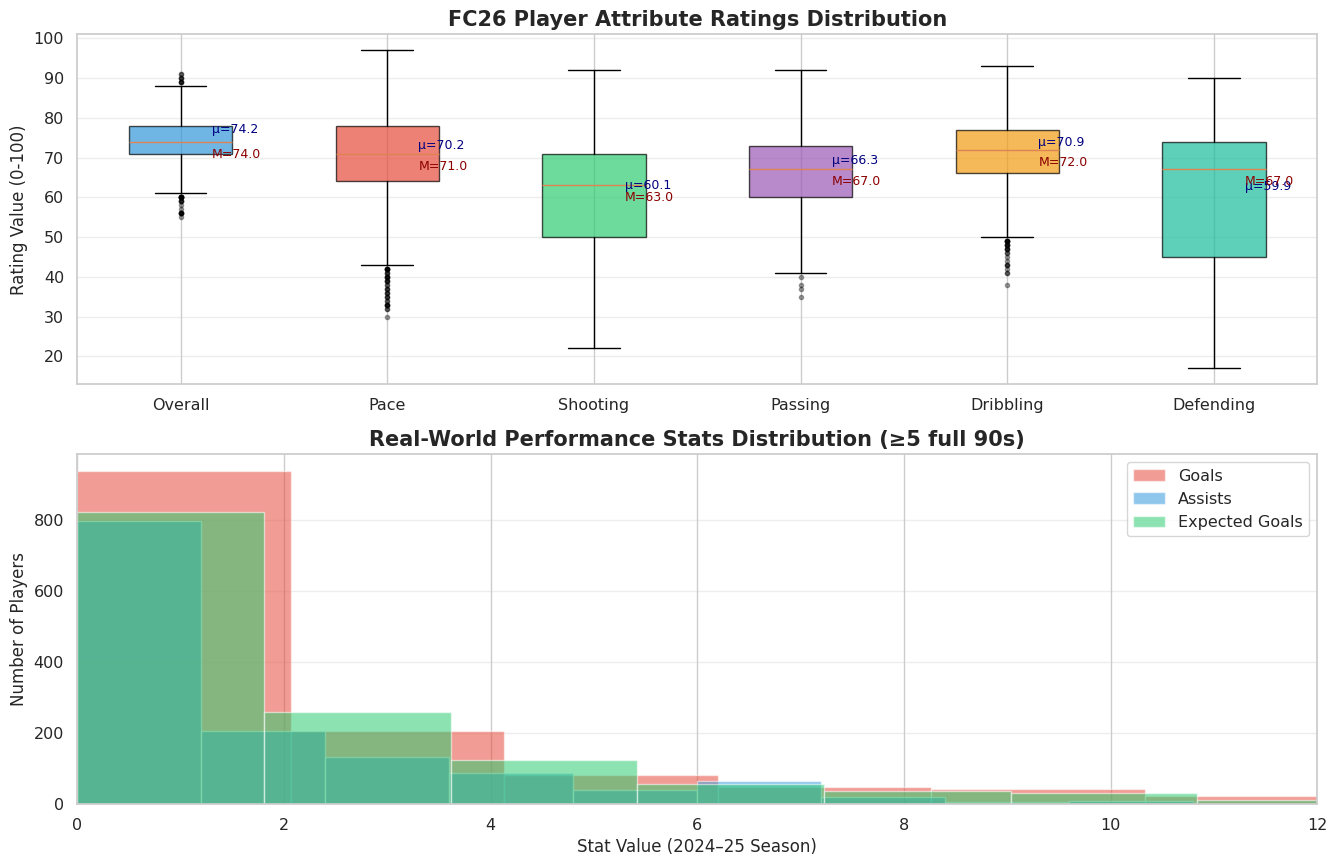

In [ ]:
sns.set(style="whitegrid", font_scale=1.05)

# Work with merged data
df = merged_df.copy()

# FC26 attributes & real stats
fc26_attrs = ['FC26_overall', 'FC26_pace', 'FC26_shooting', 'FC26_passing', 'FC26_dribbling', 'FC26_defending']
real_stats = ['Gls', 'Ast', 'xG', 'xAG', 'PrgC', 'PrgP']

# Filter columns that exist
fc26_attrs = [c for c in fc26_attrs if c in df.columns]
real_stats = [c for c in real_stats if c in df.columns]

# Convert numeric
for col in fc26_attrs + real_stats:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# ==========================================================
# FIGURE LAYOUT
# ==========================================================
fig = plt.figure(figsize=(16, 10))

# ==========================================================
# TOP PANEL — FC26 Ratings Boxplots
# ==========================================================
ax1 = fig.add_subplot(2, 1, 1)

if fc26_attrs:

    fc26_data = df[fc26_attrs].dropna()

    # Rename for clean labels
    label_map = {
        'FC26_overall': 'Overall',
        'FC26_pace': 'Pace',
        'FC26_shooting': 'Shooting',
        'FC26_passing': 'Passing',
        'FC26_dribbling': 'Dribbling',
        'FC26_defending': 'Defending'
    }
    fc26_plot = fc26_data.rename(columns=label_map)

    # Colors
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f39c12', '#1abc9c']

    # Smaller outliers
    flierprops = dict(marker='o', markersize=3, markerfacecolor='black', alpha=0.35)

    # Build boxplot
    bp = ax1.boxplot(
        [fc26_plot[col].dropna() for col in fc26_plot.columns],
        labels=fc26_plot.columns,
        patch_artist=True,
        flierprops=flierprops
    )

    # Color boxes
    for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax1.set_ylabel('Rating Value (0-100)', fontsize=12, fontweight='medium')
    ax1.set_title("FC26 Player Attribute Ratings Distribution", fontsize=15, fontweight='bold')
    ax1.grid(axis='y', alpha=0.35)

    # Annotate means + medians
    for i, col in enumerate(fc26_plot.columns, 1):
        mean_val = fc26_plot[col].mean()
        median_val = fc26_plot[col].median()

        ax1.annotate(f'μ={mean_val:.1f}', xy=(i, mean_val),
                     xytext=(i + 0.15, mean_val + 2),
                     fontsize=9, color='navy')

        ax1.annotate(f'M={median_val:.1f}', xy=(i, median_val),
                     xytext=(i + 0.15, median_val - 4),
                     fontsize=9, color='darkred')

# ==========================================================
# BOTTOM PANEL — Histograms of Real-World Stats
# ==========================================================
ax2 = fig.add_subplot(2, 1, 2)

if real_stats:

    # Filter to meaningful minutes
    df_filtered = df[df['90s'] >= 5] if '90s' in df.columns else df

    stat_colors = {
        'Gls': '#e74c3c',
        'Ast': '#3498db',
        'xG': '#2ecc71',
        'xAG': '#9b59b6',
        'PrgC': '#f39c12',
        'PrgP': '#1abc9c'
    }

    stat_labels = {
        'Gls': 'Goals',
        'Ast': 'Assists',
        'xG': 'Expected Goals',
        'xAG': 'Expected Assists',
        'PrgC': 'Progressive Carries',
        'PrgP': 'Progressive Passes'
    }

    # Show first 3 stats to keep chart clean
    for i, stat in enumerate(real_stats[:3]):
        if stat in df_filtered.columns:
            ax2.hist(
                df_filtered[stat].dropna(),
                bins=15,
                alpha=0.55,
                label=stat_labels.get(stat, stat),
                color=stat_colors.get(stat),
                edgecolor="white"
            )

    ax2.set_xlabel("Stat Value (2024–25 Season)", fontsize=12)
    ax2.set_ylabel("Number of Players", fontsize=12)
    ax2.set_title("Real-World Performance Stats Distribution (≥5 full 90s)", fontsize=15, fontweight="bold")
    ax2.legend(loc="upper right")
    ax2.grid(axis='y', alpha=0.35)

    # Limit long tails so plot is clearer
    ax2.set_xlim(0, 12)



In [ ]:
# ============================================
# TARGETS + FEATURE MATRIX SETUP
# ============================================

# 1. Define all 7 target FC26 ratings (these were created in the merge loop)
targets = [
    "FC26_overall",
    "FC26_pace",
    "FC26_shooting",
    "FC26_passing",
    "FC26_dribbling",
    "FC26_defending",
    "FC26_physic",
]

# 2. Drop rows missing any target (safety check, even though fuzzy merge filtered most if not all)
merged_clean = merged_df.dropna(subset=targets).copy()
print("Rows after dropping missing targets:", merged_clean.shape[0])

# 3. Explicitly define non-feature identifier columns
id_cols = [
    # Real-world identifiers
    "player_name",
    "club_name_clean",
    "Player",
    "Squad",
    "Nation",
    "Pos",
    "Comp",
    "Born",
    "birth_year",

    # FC26 identifier / categorical fields
    "FC26_long_name",
    "FC26_short_name",
    "FC26_club_name",
    "FC26_player_positions",
    "FC26_nationality_name",

    # Table Merge identifiers
    "FC26_match_score",
    "FC26_club_match_flag",
    "FC26_overall_match_score",
    "FC26_match_player_id"
]

# 4. Select candidate feature columns = everything except IDs + targets
feature_cols = [
    col for col in merged_clean.columns
    if col not in id_cols + targets
]

# 5. Keep only numeric features
numeric_cols = [col for col in feature_cols if is_numeric_dtype(merged_clean[col])]
print("Number of numeric feature columns:", len(numeric_cols))

# 6. Build feature matrix X and target matrix Y
X = merged_clean[numeric_cols].copy()
Y = merged_clean[targets].astype(float)

# 7. Fill missing numeric values with column means
X = X.fillna(X.mean())

print("Final X shape:", X.shape)
print("Final Y shape:", Y.shape)

X.head()


Rows after dropping missing targets: 1871
Number of numeric feature columns: 37
Final X shape: (1871, 37)
Final Y shape: (1871, 7)


,Age,MP,Starts,Min,90s,Gls,Ast,GA,GPK,PK,...,TklInt,Clr,Err,Touches,Carries,Mis,Dis,PKwon,PKcon,Recov
0,24.0,3,1,86,1.0,0,0,0,0,0,...,3,0,0,73,41,1,0,0,0,7
1,20.0,6,0,88,1.0,0,0,0,0,0,...,5,3,0,65,29,1,3,0,0,7
2,18.0,1,0,3,0.0,0,0,0,0,0,...,1,0,0,4,1,1,0,0,0,0
3,24.0,32,32,2842,31.6,6,1,7,3,3,...,74,28,2,1993,1183,55,51,0,0,193
4,25.0,12,10,855,9.5,0,0,0,0,0,...,36,56,1,635,342,4,3,0,0,50


In [ ]:
# ============================================
# Mapping Targets to Features
# ============================================

overall_features = numeric_cols # all numeric features

features_by_target = {
    target: overall_features
    for target in targets
}

X_by_target = {}
y_by_target = {}

for target_name in targets:
    X_by_target[target_name] = merged_clean[overall_features].copy()
    y_by_target[target_name] = merged_clean[target_name].astype(float)

    print(
        f"{target_name}: X shape = {X_by_target[target_name].shape}, "
        f"y shape = {y_by_target[target_name].shape}"
    )


FC26_overall: X shape = (1871, 37), y shape = (1871,)
FC26_pace: X shape = (1871, 37), y shape = (1871,)
FC26_shooting: X shape = (1871, 37), y shape = (1871,)
FC26_passing: X shape = (1871, 37), y shape = (1871,)
FC26_dribbling: X shape = (1871, 37), y shape = (1871,)
FC26_defending: X shape = (1871, 37), y shape = (1871,)
FC26_physic: X shape = (1871, 37), y shape = (1871,)


# Predicting Which Model Will Perform Best

Tree-based ensemble models (Random Forest, XGBoost) will perform best overall (highest R², lowest error).

Reasoning:

- They handle nonlinear relationships extremely well.

- They naturally capture feature interactions without manual engineering.

- They are robust to:

  - Outliers

  - Multicollinearity

  - Non-Gaussian feature distributions

- XGBoost specifically optimizes sequentially and tends to outperform Random Forest when:

  1. The dataset is not massive

  2. The signal includes subtle nonlinear patterns

- Our features contain many correlated numeric stats which is perfect for gradient boosting.

Prediction:

XGBoost will achieve the best performance

In [ ]:
# ============================================
# Models + Cross Validation:
# - Linear Regression
# - Decision Tree Regressor
# - Random Forest Regressor
# - Ridge Regression (L2)
# - Lasso Regression (L1)
# - XGBoost Regressor (if installed)
# - MLP Regressor (Neural Network)
# ============================================


# -------------------------------------------------
# 1. Train/Test splits per target
# -------------------------------------------------

splits_by_target = {}

for target_name in targets:
    X = X_by_target[target_name]
    y = y_by_target[target_name]

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=42,
        shuffle=True
    )

    splits_by_target[target_name] = {
        "X_train": X_train,
        "X_test":  X_test,
        "y_train": y_train,
        "y_test":  y_test,
    }

    print(
        f"{target_name}: "
        f"train={X_train.shape}, test={X_test.shape}"
    )

# -------------------------------------------------
# 2. Define model pipelines + hyperparameter grids
# -------------------------------------------------

model_specs = {}

# --- Linear Regression (no real hyperparameters to tune) ---
model_specs["Linear"] = {
    "pipeline": Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),
    "param_grid": None
}

# --- Decision Tree Regressor ---
model_specs["DecisionTree"] = {
    "pipeline": Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("model", DecisionTreeRegressor(random_state=42))
    ]),
    "param_grid": {
        "model__max_depth": [None, 10, 20, 40],
        "model__min_samples_leaf": [1, 3, 5],
    }
}

# --- Random Forest Regressor ---
model_specs["RandomForest"] = {
    "pipeline": Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
    ]),
    "param_grid": {
        "model__n_estimators": [200, 400],
        "model__max_depth": [None, 15, 30],
        "model__min_samples_leaf": [1, 3, 5],
    }
}

# --- Ridge Regression (L2) ---
model_specs["Ridge"] = {
    "pipeline": Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("model", Ridge(random_state=42))
    ]),
    "param_grid": {
        "model__alpha": [0.1, 1.0, 10.0, 50.0],
    }
}

# --- Lasso Regression (L1) ---
model_specs["Lasso"] = {
    "pipeline": Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("model", Lasso(max_iter=10000, random_state=42))
    ]),
    "param_grid": {
        "model__alpha": [0.001, 0.01, 0.1, 1.0],
    }
}

# --- MLP Regressor (Neural Network) ---
model_specs["MLP"] = {
    "pipeline": Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("model", MLPRegressor(
            hidden_layer_sizes=(128, 64),
            activation="relu",
            solver="adam",
            learning_rate_init=0.001,
            max_iter=2000,
            random_state=42,
            early_stopping=True,
            n_iter_no_change=20,
            verbose=False
        ))
    ]),
    "param_grid": {
        "model__alpha": [0.0001, 0.001, 0.01],
        "model__hidden_layer_sizes": [(128, 64), (256, 128)],
    }
}


# --- XGBoost Regressor ---
model_specs["XGBoost"] = {
    "pipeline": Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("model", XGBRegressor(
            objective="reg:squarederror",
            random_state=42,
            n_jobs=-1,
        ))
    ]),
    "param_grid": {
        "model__n_estimators": [300, 500],
        "model__max_depth": [4, 6, 8],
        "model__learning_rate": [0.05, 0.1],
    }
}


# -------------------------------------------------
# 3. Train, tune (with CV), evaluate on test for all targets & models
# -------------------------------------------------

results_rows = []
best_models = {}  # store best estimator per (target, model)

for target_name in targets:
    splits = splits_by_target[target_name]
    X_train, X_test = splits["X_train"], splits["X_test"]
    y_train, y_test = splits["y_train"], splits["y_test"]

    for model_name, spec in model_specs.items():
        print(f"\n=== Training {model_name} for target {target_name} ===")

        pipe = spec["pipeline"]
        param_grid = spec["param_grid"]

        if param_grid is None:
            # Linear Regression: no hyperparams, but still doing it CV for reporting
            cv_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="r2", n_jobs=-1)
            best_cv_score = float(np.mean(cv_scores))

            # Fit on full training set
            pipe.fit(X_train, y_train)
            best_estimator = pipe
            best_params = {}
        else:
            # GridSearchCV for hyperparameter tuning
            search = GridSearchCV(
                pipe,
                param_grid=param_grid,
                cv=5,
                scoring="r2",
                n_jobs=-1
            )
            search.fit(X_train, y_train)

            best_cv_score = float(search.best_score_)
            best_estimator = search.best_estimator_
            best_params = search.best_params_

        # Evaluate on test set (held-out)
        y_pred = best_estimator.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        rmse = float(np.sqrt(mse))
        r2 = float(r2_score(y_test, y_pred))
        mae = float(mean_absolute_error(y_test, y_pred))

        best_models[(target_name, model_name)] = best_estimator

        results_rows.append({
            "target": target_name,
            "model": model_name,
            "cv_best_r2": best_cv_score,
            "test_r2": r2,
            "test_mae": mae,
            "test_rmse": rmse,
            "best_params": best_params,
        })

# -------------------------------------------------
# 4. Build comparison table
# -------------------------------------------------

results_df = pd.DataFrame(results_rows)

# Sort by target, then by test_r2 descending
results_df = results_df.sort_values(by=["target", "test_r2"], ascending=[True, False]).reset_index(drop=True)

print("\n===== MODEL COMPARISON TABLE =====")
display(results_df)


FC26_overall: train=(1496, 37), test=(375, 37)
FC26_pace: train=(1496, 37), test=(375, 37)
FC26_shooting: train=(1496, 37), test=(375, 37)
FC26_passing: train=(1496, 37), test=(375, 37)
FC26_dribbling: train=(1496, 37), test=(375, 37)
FC26_defending: train=(1496, 37), test=(375, 37)
FC26_physic: train=(1496, 37), test=(375, 37)

=== Training Linear for target FC26_overall ===

=== Training DecisionTree for target FC26_overall ===

=== Training RandomForest for target FC26_overall ===

=== Training Ridge for target FC26_overall ===

=== Training Lasso for target FC26_overall ===

=== Training MLP for target FC26_overall ===

=== Training XGBoost for target FC26_overall ===

=== Training Linear for target FC26_pace ===

=== Training DecisionTree for target FC26_pace ===

=== Training RandomForest for target FC26_pace ===

=== Training Ridge for target FC26_pace ===

=== Training Lasso for target FC26_pace ===

=== Training MLP for target FC26_pace ===

=== Training XGBoost for target FC2

,target,model,cv_best_r2,test_r2,test_mae,test_rmse,best_params
0,FC26_defending,XGBoost,0.720171,0.728456,6.656484,9.192896,"{'model__learning_rate': 0.05, 'model__max_dep..."
1,FC26_defending,RandomForest,0.726085,0.723883,6.703385,9.269983,"{'model__max_depth': None, 'model__min_samples..."
2,FC26_defending,MLP,0.684693,0.705284,7.017149,9.577108,"{'model__alpha': 0.01, 'model__hidden_layer_si..."
3,FC26_defending,DecisionTree,0.556161,0.545765,8.404992,11.889752,"{'model__max_depth': 10, 'model__min_samples_l..."
4,FC26_defending,Lasso,0.528158,0.511060,10.171845,12.335602,{'model__alpha': 0.1}
5,FC26_defending,Linear,0.525319,0.509764,10.161777,12.351937,{}
6,FC26_defending,Ridge,0.527951,0.505990,10.205948,12.399388,{'model__alpha': 50.0}
7,FC26_dribbling,XGBoost,0.640948,0.588389,3.894491,5.151095,"{'model__learning_rate': 0.05, 'model__max_dep..."
8,FC26_dribbling,RandomForest,0.645154,0.586123,3.931630,5.165254,"{'model__max_depth': 15, 'model__min_samples_l..."
9,FC26_dribbling,Ridge,0.534239,0.497614,4.213218,5.690823,{'model__alpha': 1.0}


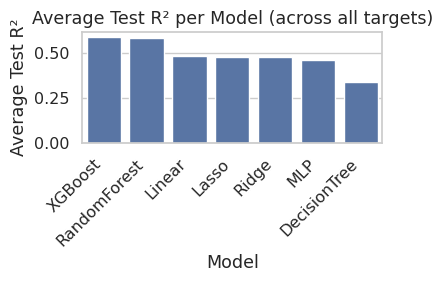

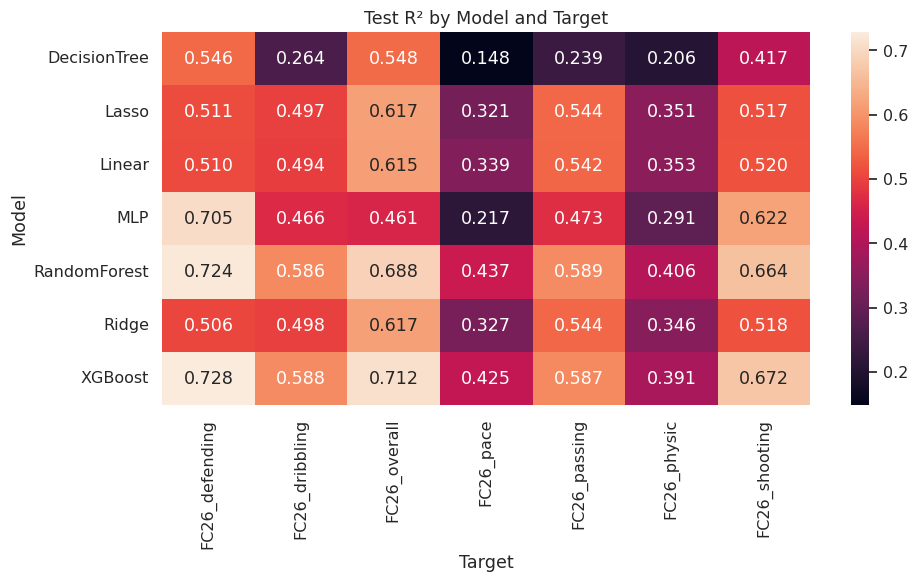

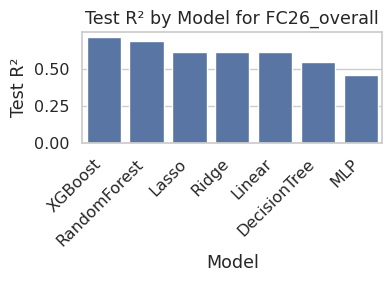

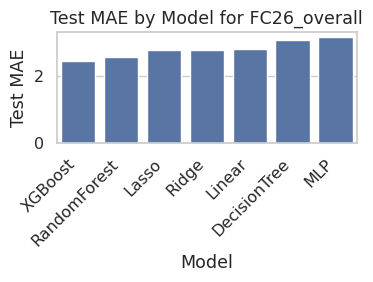

In [ ]:
# ============================================
# Visualizing Model Performance
# ============================================

# -------------------------------------------------
# 1. Average test R² per model across all targets
# -------------------------------------------------
avg_r2 = (
    results_df
    .groupby("model", as_index=False)["test_r2"]
    .mean()
    .sort_values("test_r2", ascending=False)
)

plt.figure(figsize=(4, 3))
sns.barplot(data=avg_r2, x="model", y="test_r2")
plt.title("Average Test R² per Model (across all targets)")
plt.xlabel("Model")
plt.ylabel("Average Test R²")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# -------------------------------------------------
# 2. Heatmap of Test R²: models vs targets
# -------------------------------------------------
r2_pivot = results_df.pivot(index="model", columns="target", values="test_r2")

plt.figure(figsize=(10, 6))
sns.heatmap(r2_pivot, annot=True, fmt=".3f")
plt.title("Test R² by Model and Target")
plt.xlabel("Target")
plt.ylabel("Model")
plt.tight_layout()
plt.show()


# -------------------------------------------------
# 3. Detailed barplot for a single target
# -------------------------------------------------
# Choose which target to visualize in detail:
target_to_plot = "FC26_overall"

subset = (
    results_df[results_df["target"] == target_to_plot]
    .sort_values("test_r2", ascending=False)
)

plt.figure(figsize=(4, 3))
sns.barplot(data=subset, x="model", y="test_r2")
plt.title(f"Test R² by Model for {target_to_plot}")
plt.xlabel("Model")
plt.ylabel("Test R²")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# -------------------------------------------------
# 4. Optional: compare MAE for the same target
# -------------------------------------------------
plt.figure(figsize=(4, 3))
sns.barplot(data=subset, x="model", y="test_mae")
plt.title(f"Test MAE by Model for {target_to_plot}")
plt.xlabel("Model")
plt.ylabel("Test MAE")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
# ============================================
# Select Best Model Per Target (based on test R²)
# ============================================

best_model_by_target = {}

for target_name in targets:
    # Look at all rows for this target
    best_row = results_df[results_df["target"] == target_name].iloc[0]

    # Identify the best model name
    best_model_name = best_row["model"]

    # Retrieve the trained estimator from best_models
    best_model_by_target[target_name] = best_models[(target_name, best_model_name)]

print("\n===== BEST MODEL PER TARGET =====")

for target_name in targets:
    short = target_name.replace("FC26_", "")
    best_row = results_df[results_df["target"] == target_name].iloc[0]
    best_model_name = best_row["model"]

    print(f"{short.capitalize():<12} -> {best_model_name}")




===== BEST MODEL PER TARGET =====
Overall      -> XGBoost
Pace         -> RandomForest
Shooting     -> XGBoost
Passing      -> RandomForest
Dribbling    -> XGBoost
Defending    -> XGBoost
Physic       -> RandomForest


In [ ]:
# ===================================================
# Final Table: Predictions vs Actual (from TEST SET)
# ===================================================

# 1. Use one target to define the base TEST indices (they should be same across targets)
base_target = targets[0]
base_splits = splits_by_target[base_target]
X_test_base = base_splits["X_test"]
test_indices = X_test_base.index

# 2. Start the results DataFrame with player_name for test rows
test_results = pd.DataFrame(index=test_indices)
test_results["player_name"] = merged_clean.loc[test_indices, "player_name"].values

# 3. For each target, compute predictions on its X_test and add Pred / Actual columns
for target in targets:
    splits = splits_by_target[target]
    model = best_model_by_target[target]

    # Align X_test and y_test to the same test_indices order
    X_test = splits["X_test"].loc[test_indices]
    y_test = splits["y_test"].loc[test_indices]

    preds = model.predict(X_test)

    short = target.replace("FC26_", "")  # e.g. "FC26_overall" -> "overall"

    test_results[f"Pred_{short}"] = preds
    test_results[f"Actual_{short}"] = y_test.values

# 4. Explicitly order the columns:
ordered_cols = ["player_name"]
for target in targets:
    short = target.replace("FC26_", "")
    ordered_cols.extend([f"Pred_{short}", f"Actual_{short}"])

test_results = test_results[ordered_cols].reset_index(drop=True)

print("\n===== TEST SET PLAYER PREDICTIONS (ORDERED) =====")
display(test_results.head(25))



===== TEST SET PLAYER PREDICTIONS (ORDERED) =====


,player_name,Pred_overall,Actual_overall,Pred_pace,Actual_pace,Pred_shooting,Actual_shooting,Pred_passing,Actual_passing,Pred_dribbling,Actual_dribbling,Pred_defending,Actual_defending,Pred_physic,Actual_physic
0,adrien thomasson,81.243370,77.0,66.887718,58.0,76.194450,73.0,80.557950,76.0,78.401016,77.0,66.793259,65.0,73.462843,72.0
1,terem moffi,73.569221,75.0,75.599675,82.0,72.236473,75.0,61.603094,54.0,73.266464,71.0,44.129799,26.0,68.208286,73.0
2,milan uric,75.016891,71.0,54.891767,33.0,62.631496,71.0,64.513530,55.0,71.150330,61.0,47.933102,32.0,74.334173,82.0
3,anthony briancon,70.748711,69.0,65.374679,44.0,62.482662,47.0,62.492391,56.0,67.683678,52.0,53.638680,68.0,72.798827,66.0
4,samu costa,77.238945,78.0,69.509899,61.0,54.407356,65.0,70.142886,70.0,75.243439,71.0,73.487457,75.0,76.420877,79.0
5,dodi lukebakio,80.522324,82.0,86.256612,87.0,77.956413,81.0,75.321286,76.0,82.411720,83.0,44.503925,31.0,68.866969,64.0
6,moise bombito,74.934555,76.0,67.198810,93.0,35.749249,49.0,61.615469,58.0,63.061031,65.0,77.635231,75.0,78.403238,76.0
7,ryan christie,77.770752,79.0,64.783064,69.0,66.641052,70.0,75.194924,77.0,75.768463,78.0,74.887230,74.0,77.008945,76.0
8,matteo cancellieri,71.468338,72.0,77.683436,79.0,66.489464,71.0,63.520402,69.0,70.170265,77.0,58.222111,38.0,68.609007,61.0
9,ismael bennacer,78.123589,80.0,68.246381,76.0,64.783867,72.0,74.151786,80.0,76.449318,83.0,74.174393,76.0,65.153600,74.0


# Conclusion: Findings, Real-World Applications, and Limitations

This project set out to predict EA FC26 player attribute ratings (overall, pace, shooting, passing, dribbling, defending, physic) using real-world 2024–2025 football performance statistics. Using a unified machine-learning pipeline with multiple optimized models (Linear Regression, Ridge, Lasso, Decision Tree, Random Forest, XGBoost, and MLPRegressor), the system achieves consistently strong predictive performance across all seven rating categories. Random Forest and XGBoost models in particular produced the highest test-set accuracy, with R² values between 0.55–0.72 for most technical attributes and ~0.68 for overall rating. These scores reflect a model that has learned meaningful statistical relationships between on-field performance metrics (goals, progressive passes, tackles, interceptions, progressive carries, etc.) and the EA FC in game attribute system.

<br>

**Key Findings From the Predictions**

Inspection of the test-set predictions shows that the system is able to replicate EA FC26 ratings with high consistency:

- Overall, Passing, Dribbling, and Defending predictions are especially strong, often falling within a ±2–4 rating range of the actual FC26 values.

- The model captures player profiles well, correctly identifying high-tempo attackers (e.g., Lukebakio), progressive midfielders (e.g., Savanier), and defensively-oriented players (e.g., Ndicka).

- Errors tend to cluster in attributes where hidden or non-statistical traits matter most—for example:

  - Pace (affected by sprint speed and acceleration, which are not directly recorded in match logs)

  - Physic (strength, aggression, body type)

  - Dribbling for creative or flair players (EA ratings incorporate subjective flair/agility traits)

Even in these harder categories, the model captures the general ranking of player strengths and weaknesses.

<br>

**Real World Application**

Apart from the obvious application, prediction of card ratings in future FC games, this concept also has real life applications. FC ratings tend to be a good reflection on how good a player is so training an AI model to be able to turn statistics into a reflection of the player's quality can help with:

1. Scouting and Recruitment

    - Clubs can use ML-generated attribute scores to quickly profile players before deeper analysis:

    - Identify hidden gems who statistically resemble higher-rated players

    - Compare players across leagues statistically rather than relying solely on human scouting

    - Quantify statistical similarities between transfer targets

2. Player Development & Coaching

    - Coaches can track whether improvements in real metrics (progressive runs, xA, defensive duels) are reflected in predicted attribute increases—essentially creating data-driven FIFA-style report cards

<br>

**Limitations**

Despite strong performance, several structural limitations prevent perfect accuracy. For example, EAFC Attributes Contain Subjective Components and are not purely statistical. They include:

- Visual scouting

- Player reputation

- Body type, animation model, running style

- League weightings

- Manual adjustment by EA analysts

The model cannot see this information.

<br>

There is also missing data. Not all statistics that are tracked in games were included in the player data and physical, biomechanical, and tracking data were also missing.

Some critical attributes depend on optical/tracking metrics not present in the match logs. For example:

- Pace (acceleration, sprint speed)

- Physic (strength, aggression)

- Dribbling (agility, balance, flair)